In [5]:
import os
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from tqdm.auto import tqdm
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

sns.set_style('whitegrid')
sns.set_context("talk")
pd.set_option('display.width', 2000)

## Helper Functions

In [6]:
def read_tensorboard_logs(path, tasks, datasets, methods, epsilons, metrics=None):
    data = []
    if 'raw' in methods:
        configs = list(product(tasks, datasets, ['raw'], [0.0]))
        configs += list(product(tasks, datasets, set(methods) - {'raw'}, set(epsilons) - {0.0}))
    else:
        configs = list(product(tasks, datasets, methods, epsilons))
    
    for task, dataset, method, eps in tqdm(configs):
        version_path = os.path.join(path, f'{task}_{dataset}_{method}_{eps}')
        versions = os.listdir(version_path)
        
        for version in versions:
            event_path = os.path.join(version_path, version)
            output = subprocess.getoutput(f'find "{event_path}" -type f -name "events*"')
            event_file = output.splitlines()[-1]

            event_acc = EventAccumulator(event_file)
            event_acc.Reload()

#             eps_str = 'raw' if eps == 0.0 else str(int(eps))
            if metrics is None: 
                metrics = event_acc.scalars.Keys()
                
            for metric in metrics:
                if metric in event_acc.scalars.Keys():
                    scalars = event_acc.Scalars(metric)
                    for item in scalars:
                        if method == 'raw':
                            for fake_eps in epsilons:
                                data.append([task, dataset, method, fake_eps, version, metric, item.step, item.value])
                        else:
                            data.append([task, dataset, method, eps, version, metric, item.step, item.value])

    df = pd.DataFrame(data, columns=['task', 'dataset', 'method', 'eps', 'version', 'metric', 'step', 'value'])
    return df


def read_csv_logs(path, tasks, datasets, methods, epsilons, metrics=None):
    df_results = pd.DataFrame()
    if 'raw' in methods:
        configs = list(product(tasks, datasets, ['raw'], [0.0]))
        configs += list(product(tasks, datasets, set(methods) - {'raw'}, set(epsilons) - {0.0}))
    else:
        configs = list(product(tasks, datasets, methods, epsilons))
    
    for task, dataset, method, eps in tqdm(configs):
        version_path = os.path.join(path, f'{task}_{dataset}_{method}_{eps}')
        versions = os.listdir(version_path)
        
        for version in versions:
            csv_file = os.path.join(version_path, version, 'metrics.csv')
            df = pd.read_csv(csv_file)
            cols = set(df.columns) & set(metrics)
            df = df[cols]
            df['task'] = task
            df['dataset'] = dataset
            df['method'] = method
            df['version'] = version
            
            if method == 'raw':
                df['eps'] = [list(set(epsilons) - {0.0})] * len(df)
                df = df.explode('eps')
            else:
                df['eps'] = eps
            df_results = df_results.append(df, ignore_index=True)
            
    return df_results


def export_figure(path, df, x, y, hue, row, col, group):
    if not os.path.exists(path):
        os.makedirs(path)
    df = df.groupby([group, row, col, hue, x])[y].agg(['mean', np.std]).reset_index()
    df['filename'] = df[[group, row, col, hue]].apply(lambda row: '-'.join(row.astype(str)) + f'-{x}.txt', axis=1)
    df.groupby('filename').apply(
        lambda row: row[[x,'mean','std']].to_csv(
            os.path.join(path, row['filename'].unique().item()), 
            index=None, 
            sep=' '
        )
    )
    

# only to print latex code
def latex_output(df_results):
    df_max = df_results.applymap(
        lambda x: float(x[:4])                   # considering the mean part
    ).groupby('Dataset').apply(
        lambda x: x - x.iloc[-1]                 # calculate the diff between Raw method and others
    ).groupby('Dataset').apply(
        lambda x : x == x.iloc[-2::-1].max()     # pick the results which are closer to Raw
    )

    df_max.loc[(slice(None), 'Raw'), :] = False  # prevent making Raw results bold

    # make near optimal results bold
    df_bold = df_results.copy()
    df_bold[df_max] = df_bold[df_max].applymap(lambda x: '\\textbf{' + str(x) + '}')

    # print latex code
    df_bold.insert(3, '', '')
    latex = df_bold.to_latex(escape=False)
    for line in latex.splitlines():
        if line.find('Raw') == -1:
            print(line)
        else:
            print('\\cmidrule{2-9}')
            print(line)
            print('\\midrule')

# Estimation Error

### Effect of epsilon

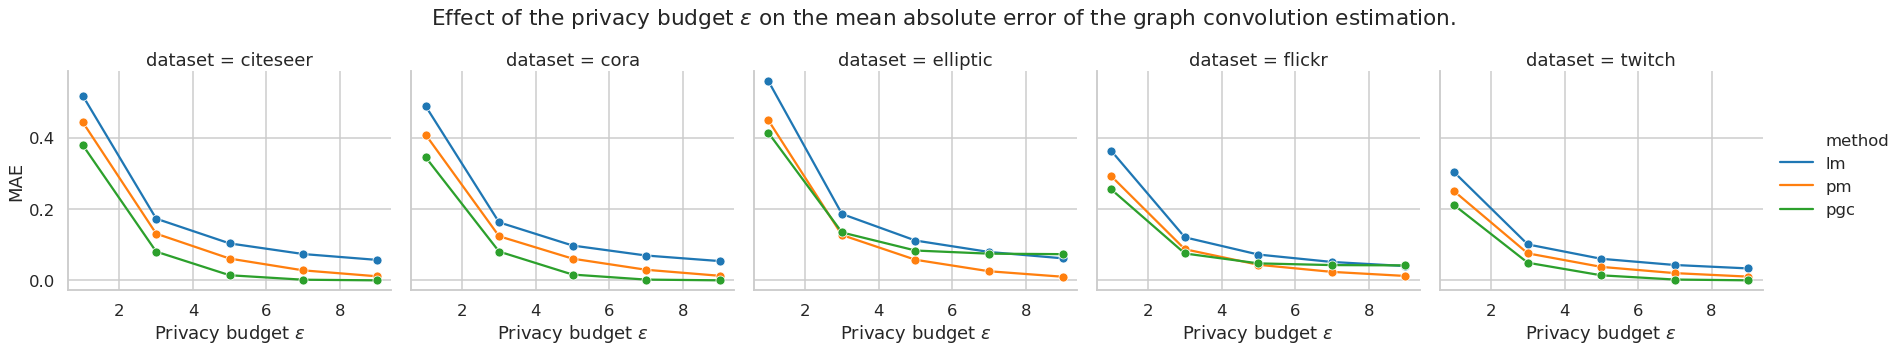

In [7]:
df = read_tensorboard_logs(
    path='results/',
    tasks=['error'],
    datasets=['citeseer', 'cora', 'elliptic', 'flickr', 'twitch'], 
    methods=['lm', 'pm', 'pgc'], 
    epsilons=[1.0, 3.0, 5.0, 7.0, 9.0],
    metrics=['mae']
)

df['eps'] = df['eps'].astype(int)

ax = sns.relplot(
    kind='line', data=df, x='eps', y='value', hue='method', col='dataset', marker='o', ci=None,
    facet_kws=dict(sharex=False, sharey=True), col_wrap=5,
)
ax.set_ylabels('MAE')
ax.set_xlabels('Privacy budget $\epsilon$')
ax.fig.suptitle('Effect of the privacy budget $\epsilon$ on the mean absolute error of the graph convolution estimation.')
ax.fig.subplots_adjust(top=.8)

export_figure('figures', df=df, x='eps', y='value', hue='method', col='dataset', row='metric', group='task')

### Effect of node degree

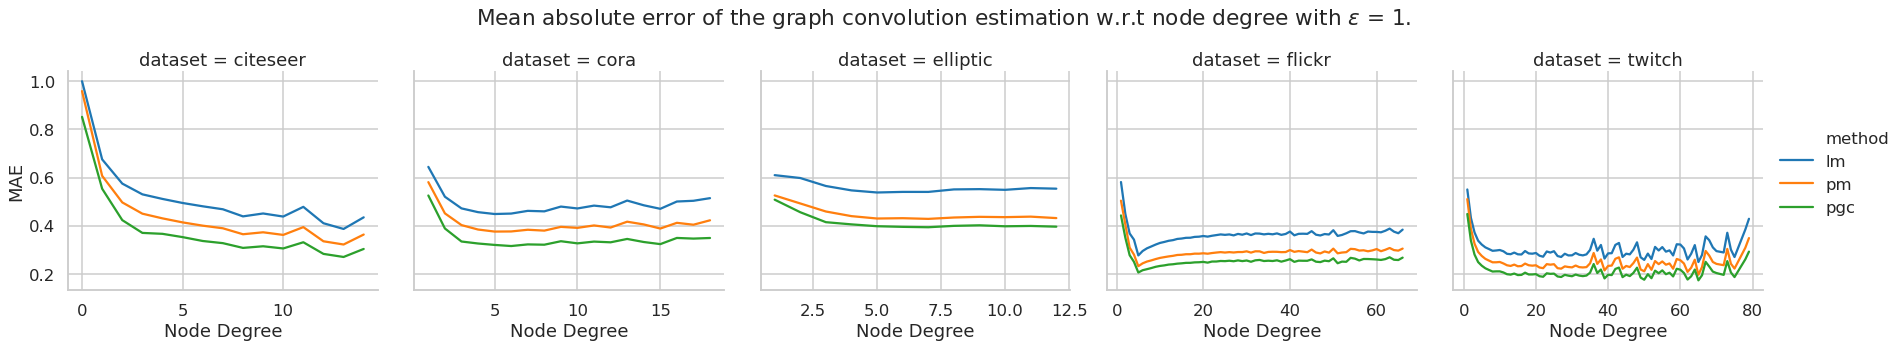

In [8]:
df = read_tensorboard_logs(
    path='results/',
    tasks=['error'],
    datasets=['citeseer', 'cora', 'elliptic', 'flickr', 'twitch'], 
    methods=['lm', 'pm', 'pgc'], 
    epsilons=[1.0],
    metrics=['mae']
)

ax = sns.relplot(
    kind='line', data=df, x='step', y='value', hue='method', col='dataset',
    facet_kws=dict(sharex=False, sharey=True), col_wrap=5,
)
ax.set_ylabels('MAE')
ax.set_xlabels('Node Degree')
ax.fig.suptitle('Mean absolute error of the graph convolution estimation w.r.t node degree with $\epsilon$ = 1.')
ax.fig.subplots_adjust(top=.8)

export_figure('figures', df=df, x='step', y='value', hue='method', col='dataset', row='metric', group='task')

# Predictive Performance

In [131]:
path = 'results/'
tasks = ['node', 'link']
datasets = ['citeseer', 'cora', 'elliptic', 'flickr', 'twitch']
methods = ['lm', 'pm', 'pgc', 'raw']
epsilons = [1.0, 5.0, 9.0]
metrics = ['test_acc', 'test_auc']

df = read_tensorboard_logs(path=path, tasks=tasks, datasets=datasets, methods=methods, epsilons=epsilons, metrics=metrics)

task_names = [{'node': 'Node Classification', 'link': 'Link Prediction'}[t] for t in tasks]
df = df.groupby(['dataset', 'task', 'method', 'eps']).agg({'value': ['mean', lambda x: np.std(x)]}).reset_index()
df = df.replace(tasks, task_names)
df = df.replace(methods, ['1-LM', '2-PM', '3-PGC', '4-Raw'])
df['dataset'] = df['dataset'].str.title()
df.columns = ['Dataset', 'Task', 'Method', '$\epsilon$', 'mean', 'std']
df['result'] = df[['mean', 'std']].apply(lambda row: '%.1f $\pm$ %.1f' % (row['mean']*100, row['std']*100), axis=1)
df = df.drop(columns=['mean', 'std']).set_index(['Dataset', 'Method', '$\epsilon$', 'Task'])
df = df.unstack().unstack()
df = df.rename(index={'1-LM': 'LM', '2-PM': 'PM', '3-PGC': 'PGC', '4-Raw': 'Raw'})
columns = [('result', task, eps) for task in task_names for eps in epsilons]
columns = pd.MultiIndex.from_tuples(columns, names=[None, 'Task', '$\epsilon$'])
df = df[columns]

df
# latex_output(df)

result                                                                                
Task            Node Classification                                 Link Prediction                                
$\epsilon$                      1.0             5.0             9.0             1.0             5.0             9.0
Dataset  Method                                                                                                    
Citeseer LM          37.0 $\pm$ 1.3  57.2 $\pm$ 2.5  68.2 $\pm$ 1.1  64.7 $\pm$ 4.1  81.7 $\pm$ 0.5  87.9 $\pm$ 1.1
         PM          37.9 $\pm$ 1.3  66.8 $\pm$ 0.9  71.7 $\pm$ 0.5  69.1 $\pm$ 6.0  86.4 $\pm$ 1.2  92.5 $\pm$ 0.7
         PGC         38.1 $\pm$ 0.9  71.1 $\pm$ 0.9  72.0 $\pm$ 0.6  70.3 $\pm$ 5.3  91.5 $\pm$ 0.7  93.3 $\pm$ 0.6
         Raw         72.1 $\pm$ 0.4  72.1 $\pm$ 0.4  72.1 $\pm$ 0.4  93.6 $\pm$ 0.4  93.6 $\pm$ 0.4  93.6 $\pm$ 0.4
Cora     LM          46.5 $\pm$ 2.5  74.3 $\pm$ 1.0  78.8 $\pm$ 0.8  79.2 $\pm$ 5.9  88.4 $\pm$ 1.1  91.5 $\pm$ 0.4
         PM          49.3 $\pm$ 3.1  78.2 $\pm$ 0.8  81.0 $\pm$ 0.4  81.9 $\pm$ 2.8  91.0 $\pm$ 0.6  92.2 $\pm$ 0.5
         PGC         51.9 $\pm$ 2.9  80.8 $\pm$ 0.6  81.8 $\pm$ 0.4  83.0 $\pm$ 1.1  92.3 $\pm$ 0.4  92.6 $\pm$ 0.2
         Raw         82.0 $\pm$ 0.3  82.0 $\pm$ 0.3  82.0 $\pm$ 0.3  92.3 $\pm$ 0.4  92.3 $\pm$ 0.4  92.3 $\pm$ 0.4
Elliptic LM          90.4 $\pm$ 0.1  91.1 $\pm$ 0.4  92.4 $\pm$ 0.5  53.8 $\pm$ 1.1  72.8 $\pm$ 4.1  79.2 $\pm$ 1.7
         PM          90.4 $\pm$ 0.1  92.0 $\pm$ 0.3  94.0 $\pm$ 0.5  58.7 $\pm$ 1.3  77.8 $\pm$ 4.1  84.7 $\pm$ 1.3
         PGC         90.4 $\pm$ 0.1  91.6 $\pm$ 0.6  92.3 $\pm$ 0.4  59.4 $\pm$ 1.6  74.8 $\pm$ 0.5  75.3 $\pm$ 0.4
         Raw         95.0 $\pm$ 0.4  95.0 $\pm$ 0.4  95.0 $\pm$ 0.4  85.7 $\pm$ 0.4  85.7 $\pm$ 0.4  85.7 $\pm$ 0.4
Flickr   LM          45.1 $\pm$ 0.4  48.7 $\pm$ 0.7  50.1 $\pm$ 0.4  67.7 $\pm$ 1.4  73.7 $\pm$ 1.3  75.7 $\pm$ 0.4
         PM          45.9 $\pm$ 0.3  49.7 $\pm$ 0.5  51.4 $\pm$ 0.1  69.5 $\pm$ 1.0  75.6 $\pm$ 0.4  76.4 $\pm$ 0.7
         PGC         45.8 $\pm$ 0.4  49.0 $\pm$ 0.3  49.5 $\pm$ 0.3  70.3 $\pm$ 1.2  75.5 $\pm$ 0.5  75.6 $\pm$ 0.5
         Raw         52.2 $\pm$ 0.1  52.2 $\pm$ 0.1  52.2 $\pm$ 0.1  76.2 $\pm$ 0.5  76.2 $\pm$ 0.5  76.2 $\pm$ 0.5
Twitch   LM          57.0 $\pm$ 1.3  59.5 $\pm$ 0.5  59.6 $\pm$ 0.8  79.2 $\pm$ 3.3  83.9 $\pm$ 0.4  85.4 $\pm$ 0.5
         PM          57.7 $\pm$ 1.0  60.2 $\pm$ 0.8  60.6 $\pm$ 0.3  81.9 $\pm$ 0.3  84.7 $\pm$ 0.3  86.3 $\pm$ 0.4
         PGC         57.5 $\pm$ 1.0  60.6 $\pm$ 0.6  61.8 $\pm$ 0.3  81.8 $\pm$ 0.4  86.0 $\pm$ 0.5  86.4 $\pm$ 0.3
         Raw         61.6 $\pm$ 0.3  61.6 $\pm$ 0.3  61.6 $\pm$ 0.3  86.7 $\pm$ 0.4  86.7 $\pm$ 0.4  86.7 $\pm$ 0.4

# Model Convergence

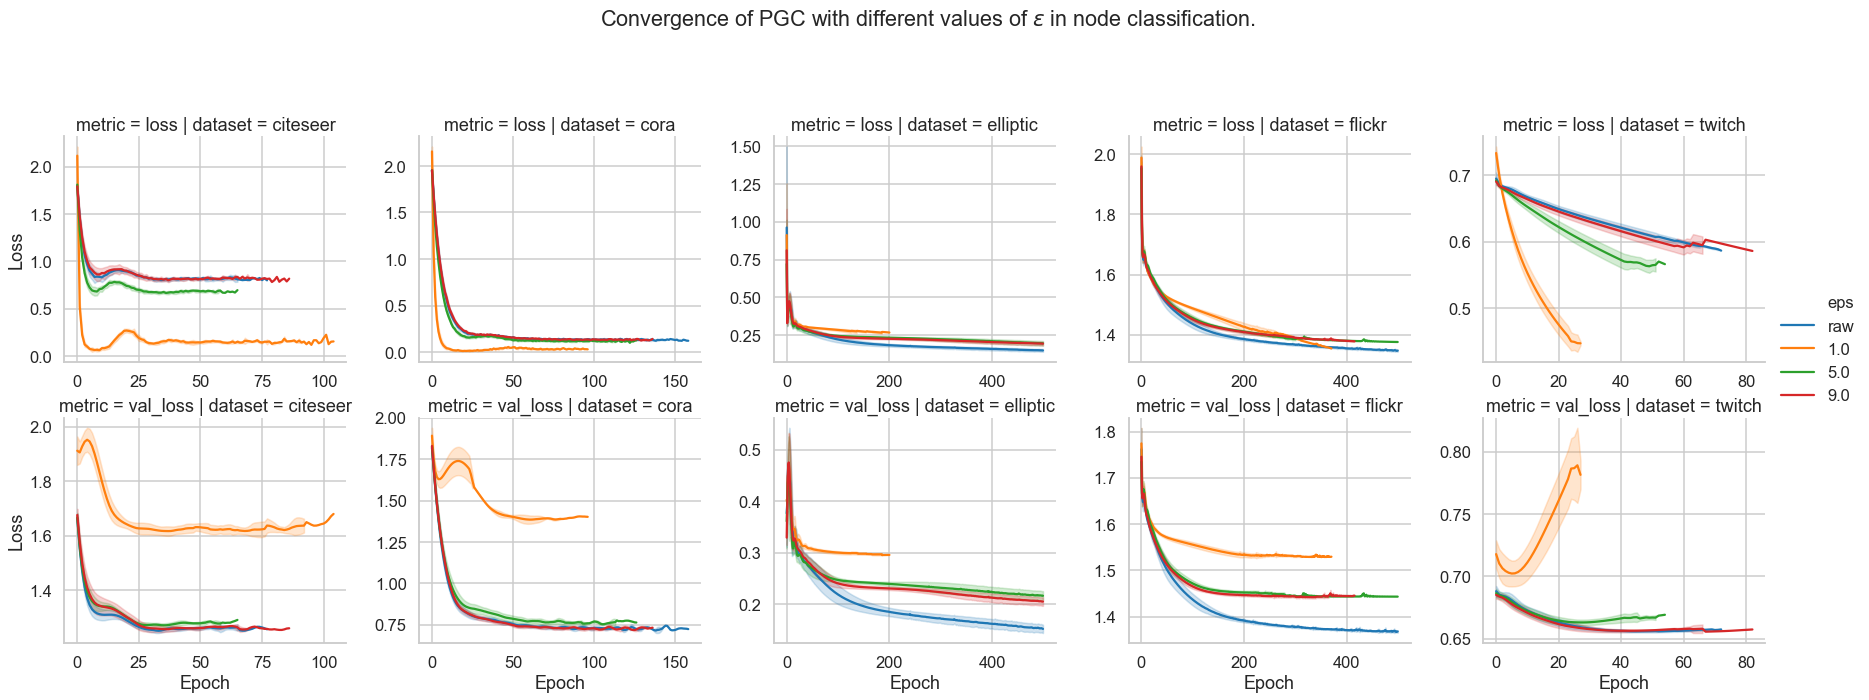

In [142]:
df = read_csv_logs(
    path='results/',
    tasks=['node'],
    datasets=['citeseer', 'cora', 'twitch'],
    methods=['pgc', 'raw'],
    metrics=['train_loss', 'val_loss'],
    epsilons=[1.0, 5.0, 9.0]
)


# df = df[df['version'] == 'version_0']
df.loc[df['method'] == 'raw', 'eps'] = 'raw'
df.drop_duplicates(inplace=True)
# df['eps'] = df['eps'].apply(lambda e: f'$\epsilon={e}$')

export_to_csv('figures', df=df, x='step', y='value', hue='eps', col='dataset', row='metric', group='task')


ax = sns.relplot(
    data=df[df['task'] == 'node'], kind='line', x='step', y='value', hue='eps', row='metric', col='dataset',
    facet_kws=dict(sharey=False, sharex=False), ci='sd'
)
ax.fig.suptitle('Convergence of PGC with different values of $\epsilon$ in node classification.')
ax.fig.subplots_adjust(top=.8)
ax.set_ylabels('Loss')
ax.set_xlabels('Epoch')

